In [93]:
import pandas as pd
import biothings_client
from pathlib import Path
from itertools import chain
from hetnet_ml.src import graph_tools as gt

from tools import biothings_processing as bp
from tools import hetnet_file_processing as hfp
from tools.stitcher import download_stitcher, organize_data
from tools.processing import expand_col_on_char, combine_group_rows_on_char, load_api_results

In [2]:
# Get Output Directory ready
this_file = '08_More_Drug_to_Target_Edges'
out_dir = Path('../2_pipeline/').resolve()
out_dir = out_dir.joinpath(this_file).joinpath('out')

if not out_dir.exists():
    out_dir.mkdir(parents=True)

In [3]:
d = load_api_results(out_dir.joinpath('stitcher_dump_{}.pkl'), False, download_stitcher)

In [4]:
d[9102]

{'USapproved': 'NDC 0143-1202',
 'kind': 'ncats.stitcher.Stitch',
 'highestPhase': 'V27W9254FZ',
 'rank': 10,
 'initiallyMarketedUS': 'V27W9254FZ',
 'initiallyMarketed': 'V27W9254FZ',
 'source': 'd58d0d292',
 'id': 819644,
 'datasource': {'id': 762185, 'key': 'd58d0d292', 'name': 'stitch_v1'},
 'labels': ['Broad Institute Drug List 2018-09-07',
  'Clinical',
  'DPD',
  'Discontinued',
  'DrugBank, December 2018',
  'Drugs@FDA',
  'FDA NDC',
  'G-SRS, July 2018',
  'Marketed',
  'NCATS Pharmaceutical Collection, April 2012',
  'NCT_REPORT.txt.gz',
  'PharmManuEncycl3rdEd.json',
  'Pharmaceutical Manufacturing Encyclopedia (Third Edition)',
  'Rancho BioSciences, December 2018',
  'SGROUP',
  'USApprovalRx',
  'dump-public-2018-07-19.gsrs',
  'npc-dump-1.2-04-25-2012_annot.sdf.gz',
  'spl_acti_rx.txt',
  'stitch_v1'],
 'sgroup': {'hash': 'd58d0d2927387097b9',
  'size': 10,
  'parent': 45204,
  'members': [{'source': 'Broad Institute Drug List 2018-09-07',
    'node': 3393,
    'payloadNo

In [5]:
data = organize_data(d)

100%|██████████| 98452/98452 [00:12<00:00, 7856.75it/s] 


In [6]:
data[9102]

{'nodes': [391968, 3394, 246117, 357908, 45206, 9944, 414425, 80795, 355903],
 'xrefs': {'InChIKey': {'ITRJWOMZKQRYTA-RFZYENFJSA-N',
   'MFYSYFVPBJMHGN-ZPOLXVRWSA-N'},
  'SMILES': {'CC(=O)OCC(=O)[C@@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@]4(C)[C@H]3C(=O)C[C@]12C',
   'C[C@]12CC(=O)C3C(CCC4=CC(=O)CC[C@]34C)C1CC[C@]2(O)C(=O)CO',
   '[H][C@@]12CC[C@](O)(C(=O)CO)[C@@]1(C)CC(=O)[C@@]1([H])[C@@]2([H])CCC2=CC(=O)CC[C@]12C',
   '[H][C@@]12CC[C@](O)(C(=O)CO)[C@@]1(C)CC(=O)[C@@]3([H])[C@@]2([H])CCC4=CC(=O)CC[C@]34C',
   '[H][C@@]12CC[C@](O)(C(=O)COC(C)=O)[C@@]1(C)CC(=O)[C@@]1([H])[C@@]2([H])CCC2=CC(=O)CC[C@]12C',
   '[H][C@@]12CC[C@](O)(C(=O)COC(C)=O)[C@@]1(C)CC(=O)[C@@]3([H])[C@@]2([H])CCC4=CC(=O)CC[C@]34C'},
  'UNII': {'883WKN7W8X', 'V27W9254FZ'},
  'CAS': {'29253-51-8', '50-04-4', '53-06-5'},
  'DRUGBANK': {'DB00741', 'DB01380', 'DB14681'},
  'CHEMBL.COMPOUND': {'CHEMBL111861', 'CHEMBL1650'},
  'CompoundName': {'CORTISONE'},
  'Iupac': {'(8S,9S,10R,13S,14S,17R)-17-hydroxy-17-(2-hydroxyacetyl)-10

## First make sense of all the compounds within the ncats inxight drugs records

The problem is that each record has several 'nodes' in it.  Sometimes these nodes represent different molecules, like different salt forms, with differnt UNIIs. This may result in a given node contains different x-refs for the same item (e.g. UNII, Drugbank, and name all correspond to the same compound on the same node). However, other times, there are different nodes within a record with the same compound. For example one node may have the UNII while the other may have the Drugbank Identifier, an yet another may have the name.  The majority of cases, though have many nodes representing many compounds, e.g. 8 nodes, for 2 compounds, with different identifiers spread across the nodes.

To remidy this we will extract x-refs of only once source for a given record, in priorty order of the global variable `CHEM_XREF_KEY_ORDER` (see `records_to_chem_nodes` fucntion). We will then use mychem.info to get the correct x-refs and name for that item.  If there are more than one uniuqe identifier in a a record (e.g. 2 salt forms of the same basic structure), all treats and targets edges will be assigned to every identifier within that record during a future step.

In [7]:
chem_nodes = hfp.records_to_chem_nodes(data)
chem_nodes.head(2)

,id,name,source,label
0,SP86R356CC,GET,UNII,Compound
1,C50C4V19SU,GET,UNII,Compound


In [8]:
len(chem_nodes)

115252

In [9]:
chem_nodes['id'].nunique()

112133

In [10]:
chem_nodes['source'].value_counts()

UNII               100312
SMILES               4581
CAS                  4271
DRUGBANK             4152
CHEMBL.COMPOUND      1177
CompoundCID           479
Iupac                 280
Name: source, dtype: int64

In [11]:
mc = biothings_client.get_client('chem')

my_chem_ids = ['UNII', 'DRUGBANK', 'CHEMBL.COMPOUND', 'CompoundCID', 'InChIKey']
to_query = chem_nodes.query('source == @my_chem_ids')['id'].unique()
len(to_query)

106093

In [12]:
mychem_res = load_api_results(out_dir.joinpath('mychem_dump_{}.pkl'), re_scrape=False, 
                              scrape_function=bp.download_mychem_ids, chem_ids=to_query)

In [13]:
chem_node_df = bp.process_chemicals_in_mychem_results(mychem_res)
len(chem_node_df)

106093

In [14]:
chem_node_df.count()

chebi_id        13404
chembl_id       25296
drugbank_id      9111
ikey            61359
mesh_id          9107
name           104859
q              106093
unii_id        100394
id             106037
source         106037
dtype: int64

In [15]:
chem_node_df.head(2)

,chebi_id,chembl_id,drugbank_id,ikey,mesh_id,name,q,unii_id,id,source
0,CHEBI:28884,CHEMBL269644,NaN,FZERHIULMFGESH-UHFFFAOYSA-N,MESH:C508827,Acetanilide,SP86R356CC,SP86R356CC,FZERHIULMFGESH-UHFFFAOYSA-N,ikey
1,NaN,NaN,NaN,SWMPGCCDXNLPED-NSCUHMNNSA-N,MESH:C005910,Acetylfuratrizine,C50C4V19SU,C50C4V19SU,SWMPGCCDXNLPED-NSCUHMNNSA-N,ikey


In [16]:
chem_node_df['source'].value_counts()

ikey        61359
unii        44276
drugbank      386
chembl         16
Name: source, dtype: int64

In [17]:
len(chem_node_df)

106093

In [18]:
chem_node_df['id'].nunique()

105893

In [19]:
len(chem_node_df.dropna(subset=['id']))

106037

In [20]:
# Get a map from inxight_id to the new mychem ID
inxight_to_chem_id = chem_node_df.set_index('q')['id'].to_dict()

# Get rid of drugs that were not found...
chem_node_df = chem_node_df.dropna(subset=['id']).drop_duplicates(subset=['id']).drop('q', axis=1)
len(chem_node_df)

105893

In [21]:
chem_node_df['label'] = "Compound"
chem_node_df = gt.order_cols(chem_node_df)

In [22]:
chem_node_df.head(2)

,id,name,label,chebi_id,chembl_id,drugbank_id,ikey,mesh_id,unii_id,source
0,FZERHIULMFGESH-UHFFFAOYSA-N,Acetanilide,Compound,CHEBI:28884,CHEMBL269644,NaN,FZERHIULMFGESH-UHFFFAOYSA-N,MESH:C508827,SP86R356CC,ikey
1,SWMPGCCDXNLPED-NSCUHMNNSA-N,Acetylfuratrizine,Compound,NaN,NaN,NaN,SWMPGCCDXNLPED-NSCUHMNNSA-N,MESH:C005910,C50C4V19SU,ikey


## Sort out the targets

Targets are a mess, there are many different identifiers for targets, however one of the primary identifiers is the ChEMBL.Target which are not widely used by other data-sources and do not x-ref well to other databases. Ideally we want Entrez Gene IDs for any gene targets. We can get there thorugh either ENSEBL gene ids, or UniProt identifiers. However, getting xrefs from ChEMBL.Targets to either of these will require use of the ChEMBL API.

There are also many targets that do not qualify as protein or gene targets, so they will not be mappable to Entrez. This may include Organisms, Cell Types, Nuclaic Acids, or Small Molecules. We will keep the ChEMBL identifier in this case, but also keep all x-refs in case we need to perform future identifier resolution.

In [23]:
targets = hfp.records_to_target_nodes(data)
len(targets)

5899

In [24]:
targets['id_source'].value_counts()

ChEMBL             2546
UniProt            1843
Other               869
GO Cell Process     530
KEGG Pathway         56
Wiki Pathway         55
Name: id_source, dtype: int64

In [25]:
chembl_targets = targets.query('id_source == "ChEMBL"')['id'].unique()
len(chembl_targets)

2546

In [26]:
chembl_api_res = load_api_results(out_dir.joinpath('chembl_targets_dump_{}.pkl'), False, 
                              hfp.download_chembl_targets, target_ids=chembl_targets)

In [27]:
ct_df = hfp.process_chembl_targets_api(chembl_api_res)
len(ct_df)

235079

In [28]:
ct_df.head(2)

,component_id,component_type,organism,pref_name,target_chembl_id,target_type,tax_id,xref_id,xref_name,xref_src_db
0,2333,PROTEIN,Homo sapiens,Tyrosine-protein kinase ABL2,CHEMBL4014,SINGLE PROTEIN,9606,ENSG00000143322,None,EnsemblGene
1,2333,PROTEIN,Homo sapiens,Tyrosine-protein kinase ABL2,CHEMBL4014,SINGLE PROTEIN,9606,GO:0005737,cytoplasm,GoComponent


In [29]:
ct_df['xref_src_db'].value_counts()

GoProcess              62309
PDBe                   39805
GoComponent            29767
GoFunction             29749
InterPro               21818
UniProt                15966
Reactome               15497
Pfam                    6760
IntAct                  2609
EnsemblGene             2574
ExpressionAtlas         2146
PharmGKB                2121
GuideToPHARMACOLOGY     1755
Pharos                  1175
CGD                      659
TIMBAL                    84
Name: xref_src_db, dtype: int64

In [30]:
ct_df.query('xref_src_db == "InterPro"')

,component_id,component_type,organism,pref_name,target_chembl_id,target_type,tax_id,xref_id,xref_name,xref_src_db
40,2333,PROTEIN,Homo sapiens,Tyrosine-protein kinase ABL2,CHEMBL4014,SINGLE PROTEIN,9606,IPR000719,Prot_kinase_dom.,InterPro
41,2333,PROTEIN,Homo sapiens,Tyrosine-protein kinase ABL2,CHEMBL4014,SINGLE PROTEIN,9606,IPR000980,SH2.,InterPro
42,2333,PROTEIN,Homo sapiens,Tyrosine-protein kinase ABL2,CHEMBL4014,SINGLE PROTEIN,9606,IPR001245,Ser-Thr/Tyr_kinase_cat_dom.,InterPro
43,2333,PROTEIN,Homo sapiens,Tyrosine-protein kinase ABL2,CHEMBL4014,SINGLE PROTEIN,9606,IPR001452,SH3_domain.,InterPro
44,2333,PROTEIN,Homo sapiens,Tyrosine-protein kinase ABL2,CHEMBL4014,SINGLE PROTEIN,9606,IPR008266,Tyr_kinase_AS.,InterPro
45,2333,PROTEIN,Homo sapiens,Tyrosine-protein kinase ABL2,CHEMBL4014,SINGLE PROTEIN,9606,IPR011009,Kinase-like_dom_sf.,InterPro
46,2333,PROTEIN,Homo sapiens,Tyrosine-protein kinase ABL2,CHEMBL4014,SINGLE PROTEIN,9606,IPR015015,F-actin_binding.,InterPro
47,2333,PROTEIN,Homo sapiens,Tyrosine-protein kinase ABL2,CHEMBL4014,SINGLE PROTEIN,9606,IPR017441,Protein_kinase_ATP_BS.,InterPro
48,2333,PROTEIN,Homo sapiens,Tyrosine-protein kinase ABL2,CHEMBL4014,SINGLE PROTEIN,9606,IPR020635,Tyr_kinase_cat_dom.,InterPro
49,2333,PROTEIN,Homo sapiens,Tyrosine-protein kinase ABL2,CHEMBL4014,SINGLE PROTEIN,9606,IPR035837,ABL_SH2.,InterPro


In [31]:
ct_df.drop_duplicates(subset=['component_id'])['target_type'].value_counts()

SINGLE PROTEIN                  1652
PROTEIN FAMILY                   418
PROTEIN COMPLEX                  256
PROTEIN NUCLEIC-ACID COMPLEX     224
PROTEIN COMPLEX GROUP            205
SELECTIVITY GROUP                 15
PROTEIN-PROTEIN INTERACTION        5
CHIMERIC PROTEIN                   2
ORGANISM                           1
Name: target_type, dtype: int64

In [32]:
ct_df.drop_duplicates(subset=['target_chembl_id'])['target_type'].value_counts()

SINGLE PROTEIN                  1907
PROTEIN FAMILY                   154
ORGANISM                         149
PROTEIN COMPLEX                  138
CELL-LINE                         87
PROTEIN COMPLEX GROUP             39
SELECTIVITY GROUP                 25
NUCLEIC-ACID                      12
METAL                              8
SMALL MOLECULE                     8
PROTEIN NUCLEIC-ACID COMPLEX       4
PROTEIN-PROTEIN INTERACTION        4
SUBCELLULAR                        4
UNKNOWN                            3
MACROMOLECULE                      2
CHIMERIC PROTEIN                   1
Name: target_type, dtype: int64

In [33]:
ct_df.query('target_type == "PROTEIN FAMILY"')['xref_src_db'].unique()

array(['GoComponent', 'GoFunction', 'GoProcess', 'InterPro', 'PDBe',
       'Pfam', 'UniProt', 'EnsemblGene', 'ExpressionAtlas',
       'GuideToPHARMACOLOGY', 'IntAct', 'PharmGKB', 'Reactome', 'CGD',
       'Pharos', 'TIMBAL'], dtype=object)

In [34]:
ct_df = hfp.select_chembl_target_xref(ct_df)

len(ct_df)

3885

In [35]:
set(chembl_targets) - set(ct_df['target_chembl_id'].unique())

{'CHEMBL614639'}

looks like just one didn't get a result

In [36]:
found_ids = ct_df['target_chembl_id'].unique()
targets.query('id not in @found_ids and id_source == "ChEMBL"')

,id,name,label,id_source
1613,CHEMBL614639,Lipopolysaccharide,Target,ChEMBL


CHEMBL614639 returns no results... This may be the proper identifier for LPS?   
https://www.ebi.ac.uk/chembl/target_report_card/CHEMBL3580508/

In [37]:
ct_df['target_chembl_id'].nunique()

2545

In [38]:
len(targets)

5899

In [39]:
targets.nunique()

id           5708
name         3641
label           1
id_source       6
dtype: int64

In [40]:
targets = pd.merge(targets, ct_df, left_on=['id'], right_on=['target_chembl_id'], how='left')
targets.head()

,id,name,label,id_source,component_id,component_type,organism,pref_name,target_chembl_id,target_type,tax_id,xref_id,xref_name,xref_src_db
0,CHEMBL2111375,Vascular endothelial growth factor receptor 2 ...,Target,ChEMBL,359,PROTEIN,Homo sapiens,Vascular endothelial growth factor receptor 2 ...,CHEMBL2111375,SELECTIVITY GROUP,9606,ENSG00000128052,None,EnsemblGene
1,CHEMBL2111375,Vascular endothelial growth factor receptor 2 ...,Target,ChEMBL,4960,PROTEIN,Homo sapiens,Vascular endothelial growth factor receptor 2 ...,CHEMBL2111375,SELECTIVITY GROUP,9606,ENSG00000120156,None,EnsemblGene
2,CHEMBL3199,Acetylcholinesterase,Target,ChEMBL,1522,PROTEIN,Rattus norvegicus,Acetylcholinesterase,CHEMBL3199,SINGLE PROTEIN,10116,P37136,None,UniProt
3,Prostaglandin E2 production,None,Target,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,O75460,Serine/threonine-protein kinase/endoribonuclea...,Target,UniProt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Use mygene.info to get the proper gene xrefs

We will now get the xrefs from esembel and uniprot to entrez with mygene.info

In [41]:
import biothings_client
mg = biothings_client.get_client('gene')

ensembel_xref = mg.getgenes(targets.query('xref_src_db == "EnsemblGene"')['xref_id'].unique(), fields=['entrezgene'])
ensembel_map = {g['query']: g.get('entrezgene', float('nan')) for g in ensembel_xref}

querying 1-1000...done.
querying 1001-1720...done.


In [42]:
prots = targets.query('xref_src_db == "UniProt"')['xref_id'].unique()
uniprot_xref = mg.querymany(prots, scopes='uniprot', fileds=['entrezgene'], size=50, returnall=True)

querying 1-1000...done.
querying 1001-1085...done.
Finished.
42 input query terms found dup hits:
	[('O08726', 2), ('P0A4A8', 2), ('P66393', 2), ('Q8CWQ0', 2), ('P0A4B4', 2), ('P66473', 2), ('P0A4B6'
536 input query terms found no hit:
	['F1LNZ5', 'P00591', 'L0TBN4', 'Q9Z308', 'P13953', 'Q2KHT0', 'D6VV64', 'J9VB15', 'Q9WKE8', 'Q97SV6',


In [43]:
uniprot_map = bp.make_mg_uniprot_map(uniprot_xref)

In [44]:
# Also some uniprot ids in inxighight without having to go through chembl
uniprot_targets = targets.query('id_source == "UniProt"')['id'].unique()
r = mg.querymany(uniprot_targets, scopes='uniprot', fields=['entrezgene'], size=50, returnall=True)

uniprot_map = {**bp.make_mg_uniprot_map(r), **uniprot_map}

querying 1-1000...done.
querying 1001-1652...done.
Finished.
15 input query terms found dup hits:
	[('P31941', 2), ('P62593', 38), ('P97612', 2), ('P0A7S3', 2), ('P36544', 2), ('P35226', 2), ('P9WPS1
290 input query terms found no hit:
	['Q9UCB0', 'P50166', 'Q9NY73', 'Q64064', 'Q9UE50', 'Q9UDG8', 'Q9UG49', 'Q99981', 'Q6B4V6', 'Q9UME3',


In [45]:
# Map over these new identifiers
targets['new_id'] = targets['xref_id'].map(ensembel_map)
targets['new_id'] = targets['new_id'].fillna(targets['xref_id'].map(uniprot_map))
targets['new_id'] = targets['new_id'].fillna(targets['id'].map(uniprot_map))

entrez_idx = targets[~targets['new_id'].isnull()].index
other_idx = targets[targets['new_id'].isnull()].index
targets.loc[entrez_idx, 'source'] = 'entrez'
targets.loc[other_idx, 'new_id'] = targets.loc[other_idx, 'id']
targets.loc[other_idx, 'source'] = targets.loc[other_idx, 'id_source']

targets['source'].value_counts()

entrez             4390
Other               869
ChEMBL              860
GO Cell Process     530
UniProt             479
KEGG Pathway         56
Wiki Pathway         55
Name: source, dtype: int64

In [46]:
len(targets)

7239

#### Sanity check the targets

In [47]:
targets.replace("", float('nan')).count()

id                  7050
name                6370
label               7239
id_source           7239
component_id        3612
component_type      3612
organism            3885
pref_name           3885
target_chembl_id    3885
target_type         3885
tax_id              3885
xref_id             3612
xref_name           3612
xref_src_db         3612
new_id              7050
source              7239
dtype: int64

There appear to be some targets that either were mising an identifier or a name when first extracted

In [48]:
targets[targets.replace("", float('nan'))['name'].isnull()].sample(10)

,id,name,label,id_source,component_id,component_type,organism,pref_name,target_chembl_id,target_type,tax_id,xref_id,xref_name,xref_src_db,new_id,source
5741,Staphylococcus aureus toxic shock syndrome tox...,None,Target,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Staphylococcus aureus toxic shock syndrome tox...,Other
2701,Metallic ions,None,Target,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Metallic ions,Other
961,Low-density lipoprotein (LDL) oxidation,None,Target,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low-density lipoprotein (LDL) oxidation,Other
5796,Thyroid carcinoma cell lines,None,Target,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Thyroid carcinoma cell lines,Other
1856,nerve conduction,None,Target,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nerve conduction,Other
6664,Ca2+-transporting ATPase,None,Target,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ca2+-transporting ATPase,Other
452,P2X2/3 receptor,None,Target,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P2X2/3 receptor,Other
6362,PubChem CID:26623,None,Target,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PubChem CID:26623,Other
566,proteins,None,Target,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,proteins,Other
6387,BK channels,None,Target,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BK channels,Other


So the ones missing a name actually look like thye have an their name as an identifier.  This is problematic and will making reolving these entries time-consuming and difficult.

First let's check how many appear to be properly annotated

In [49]:
len(targets.replace("", float('nan')).dropna(subset=['id', 'new_id', 'name']))

6181

Losing around 1000 targets would mean about a 15% reduction in targets...

This may have a much smaller effect on edges though, as those may represnet uncommon targets while other targets may be repeatedly used.  We will have to look at the Chem-Target Edges first to be sure.

## Chem-Target Edges

In [50]:
tgt_edges = hfp.records_to_target_edges(data)
len(tgt_edges)

34234

In [51]:
tgt_edges.head(2)

,comp_id,target_id,interaction
0,LCH760E9T7,CHEMBL2363072,Agonist
1,BK59Y5A02O,CHEMBL2363072,Agonist


First map the chem identifiers to their proper node identifiers

In [52]:
tgt_edges['start_id'] = tgt_edges['comp_id'].map(inxight_to_chem_id)
len(tgt_edges)

34234

Now check how many edges are lost due to 1000 targets not being mapped to a stable identifier...

In [53]:
print('Raw chem-target edges: {:,}'.format(len(tgt_edges)))
print('Removing chem-targets with null values: {:,}'.format(len(tgt_edges.dropna())))
unique_tgt_edges = len(tgt_edges.dropna().drop_duplicates())
print('Removing duplicated chem-targets: {:,}'.format(unique_tgt_edges))

target_ids = targets.dropna(subset=['id', 'new_id', 'name'])['id'].unique()
n_edge_in_tgt = len(tgt_edges.dropna().drop_duplicates().query('target_id in @target_ids'))

print('Resulting chem-target edges with target id: {:,}'.format(n_edge_in_tgt))
print('Chem-target edges reduced by {:2.2%} due to un-mappable target identifiers'.format(
    1 - (n_edge_in_tgt/unique_tgt_edges)))

Raw chem-target edges: 34,234
Removing chem-targets with null values: 30,124
Removing duplicated chem-targets: 28,427
Resulting chem-target edges with target id: 26,868
Chem-target edges reduced by 5.48% due to un-mappable target identifiers


5.48% is not ideal, but acceptable considering the amount of work that would be required to map the remaining 1000 targets to some kind of stable identifier

Finalize target node information

In [54]:
targets = targets.replace("", float('nan')).dropna(subset=['id', 'new_id', 'name'])
targets['source'].value_counts()

entrez             4390
ChEMBL              860
GO Cell Process     530
UniProt             290
KEGG Pathway         56
Wiki Pathway         55
Name: source, dtype: int64

In [55]:
inxight_to_target_id = targets.set_index('id')['new_id'].to_dict()
tgt_edges['end_id'] = tgt_edges['target_id'].map(inxight_to_target_id)

In [56]:
tgt_edges = tgt_edges.dropna().drop_duplicates(subset=['start_id', 'end_id'])
print('{:,}'.format(len(tgt_edges)))

25,951


In [57]:
tgt_edges.head(2)

,comp_id,target_id,interaction,start_id,end_id
0,LCH760E9T7,CHEMBL2363072,Agonist,IHUNBGSDBOWDMA-AQFIFDHZSA-N,5914
1,BK59Y5A02O,CHEMBL2363072,Agonist,IHUNBGSDBOWDMA-UGOGCBOOSA-N,5914


In [58]:
tgt_edges['source'] = 'inxight_drugs'
tgt_edges = tgt_edges.rename(columns={'interaction': 'type'})
tgt_edges['type'] = tgt_edges['type'].str.lower()
tgt_edges = tgt_edges.drop(['comp_id', 'target_id'], axis=1)
tgt_edges = gt.order_cols(tgt_edges)
tgt_edges.head(2)

,start_id,end_id,type,source
0,IHUNBGSDBOWDMA-AQFIFDHZSA-N,5914,agonist,inxight_drugs
1,IHUNBGSDBOWDMA-UGOGCBOOSA-N,5914,agonist,inxight_drugs


#### Final fixes on the target nodes

In [59]:
len(targets)

6181

In [60]:
len(targets.drop_duplicates(subset=['new_id']))

4440

In [61]:
# those with duplicate IDs, what's the source?
targets[targets['new_id'].duplicated(keep=False)]['id_source'].value_counts()

ChEMBL     2019
UniProt     764
Name: id_source, dtype: int64

In [62]:
# Chembl targets have better annotations... lets keep those...
drop_idx = targets[targets['new_id'].duplicated(keep=False)]['xref_src_db'].isnull()
drop_idx = drop_idx[drop_idx].index

targets.loc[drop_idx].count()

id                  764
name                764
label               764
id_source           764
component_id          0
component_type        0
organism              0
pref_name             0
target_chembl_id      0
target_type           0
tax_id                0
xref_id               0
xref_name             0
xref_src_db           0
new_id              764
source              764
dtype: int64

All duplicated and missing organism info... 

In [63]:
targets = targets.drop(drop_idx)

Now we will drop duplicates... would be good if we kept xrefs to other dbs, just in case...

In [64]:
targets['x_ref_src_id'] = targets['xref_src_db']+':'+targets['xref_id']

In [65]:
targets = combine_group_rows_on_char(targets, ['new_id'], ['x_ref_src_id'])
drop_cols = ['id', 'id_source', 'component_id', 'component_type', 'organism', 'pref_name', 'xref_id',
             'xref_name', 'xref_src_db']
targets = targets.drop(drop_cols, axis=1)
targets = targets.rename(columns={'new_id': 'id', 'x_ref_src_id': 'xrefs', 'source': 'id_source'})
targets = gt.order_cols(targets)
targets.head(2)

,id,name,label,target_chembl_id,target_type,tax_id,id_source,xrefs
0,100,Adenosine deaminase,Target,CHEMBL1910,SINGLE PROTEIN,9606,entrez,EnsemblGene:ENSG00000196839
1,1000,Cadherin-2,Target,CHEMBL1697669,SINGLE PROTEIN,9606,entrez,EnsemblGene:ENSG00000170558


## Conditions (diseases)

In [66]:
conditions = hfp.records_to_condition_nodes(data)
len(conditions)

4625

In [67]:
conditions['id'] = conditions['id'].fillna(conditions['doid'])

In [68]:
len(conditions.dropna(subset=['id']))

4530

In [69]:
conditions[conditions['id'].isnull()].sample(10)

,id,name,label,doid
1559,None,Opaque medium in the bronchi,Condition,None
4373,None,Contrast agent for MRI,Condition,None
1957,None,Chromium deficiency,Condition,None
2659,None,Joint and muscular pain,Condition,None
2049,None,Vagus nerve activation,Condition,None
1953,None,Ideomotor deficits,Condition,None
1469,None,Respiratory symptoms in cystic fibrosis (CF) p...,Condition,None
326,None,skin cleasing,Condition,None
914,None,Beard growth,Condition,None
3603,None,Disorders of vigilance,Condition,None


looks more like symtptoms... may be able to pick these up with mydisease.info and get hpo, umls, or other idnetifiers.. but for now they're not classified as diseases so we will drop them from the network.

In [70]:
diseases = conditions[~conditions['id'].isnull()].reset_index(drop=True)
conditions = conditions[conditions['id'].isnull()].reset_index(drop=True)
conditions['id'] = conditions['name']
diseases['label'] = 'Disease'
len(diseases), len(conditions)

(4530, 95)

#### Indication edges (drug treats disease)

In [71]:
ind_edges = hfp.records_to_treats_edges(data)
len(ind_edges)

31808

In [72]:
ind_edges.head(2)

,comp_id,date,doid,meshid,modality,name,phase
0,LCH760E9T7,1996-10-28,DOID:8893,MESH:D011565,Palliative,Psoriasis,Approved
1,BK59Y5A02O,1996-10-28,DOID:8893,MESH:D011565,Palliative,Psoriasis,Approved


In [73]:
ind_edges = ind_edges.dropna(subset=['doid', 'meshid'], how='all')

In [74]:
len(ind_edges)

30626

In [75]:
ind_edges['start_id'] = ind_edges['comp_id'].map(inxight_to_chem_id)
ind_edges['end_id'] = ind_edges['meshid'].fillna(ind_edges['doid'])

ind_edges = ind_edges.drop(['comp_id', 'doid', 'meshid', 'name'], axis=1)
ind_edges = ind_edges.dropna(subset=['start_id'])
ind_edges = ind_edges.drop_duplicates()
len(ind_edges)

29760

In [76]:
ind_edges.count()

date        10821
modality    29759
phase       29757
start_id    29760
end_id      29760
dtype: int64

In [77]:
ind_edges['phase'].value_counts()

Approved              15600
Preclinical            3087
Phase II               2981
Basic research         2401
Not Provided           1601
Phase III              1565
Phase I                1318
Withdrawn               506
Natural Metabolite      442
Phase IV                256
Name: phase, dtype: int64

In [78]:
ind_edges['modality'].value_counts()

Primary                23450
Palliative              2789
Preventing              1661
Diagnostic              1219
Secondary                321
Inactive ingredient      310
Preventive                 9
Name: modality, dtype: int64

In [79]:
ind_edges.head(2)

,date,modality,phase,start_id,end_id
0,1996-10-28,Palliative,Approved,IHUNBGSDBOWDMA-AQFIFDHZSA-N,MESH:D011565
1,1996-10-28,Palliative,Approved,IHUNBGSDBOWDMA-UGOGCBOOSA-N,MESH:D011565


In [80]:
ind_edges.query('modality == "Preventive"')

,date,modality,phase,start_id,end_id
16990,1949-05-17,Preventive,Natural Metabolite,81G40H8B0T,MESH:D014802
16991,1949-05-17,Preventive,Natural Metabolite,FPIPGXGPPPQFEQ-OVSJKPMPSA-N,MESH:D014802
16992,1949-05-17,Preventive,Natural Metabolite,VYGQUTWHTHXGQB-FFHKNEKCSA-N,MESH:D014802
16993,1949-05-17,Preventive,Natural Metabolite,QGNJRVVDBSJHIZ-QHLGVNSISA-N,MESH:D014802
27830,1981-12-31,Preventive,Approved,ZJTLZYDQJHKRMQ-UHFFFAOYSA-N,MESH:D006470
27831,1981-12-31,Preventive,Approved,QIWDGSYHBCMXSI-UHFFFAOYSA-J,MESH:D006470
27832,1981-12-31,Preventive,Approved,JTNHOVZOOVVGHI-UHFFFAOYSA-N,MESH:D006470
27833,1981-12-31,Preventive,Approved,GZBACHSOZNEZOG-UHFFFAOYSA-J,MESH:D006470
29355,None,Preventive,Approved,RYWSYCQQUDFMAU-UHFFFAOYSA-N,MESH:D007020


In [81]:
ind_edges = ind_edges.rename(columns={'modality': 'type'})
ind_edges['source'] = 'inxight_drugs'
ind_edges = gt.order_cols(ind_edges)
ind_edges.head(2)

,start_id,end_id,type,date,phase,source
0,IHUNBGSDBOWDMA-AQFIFDHZSA-N,MESH:D011565,Palliative,1996-10-28,Approved,inxight_drugs
1,IHUNBGSDBOWDMA-UGOGCBOOSA-N,MESH:D011565,Palliative,1996-10-28,Approved,inxight_drugs


## Have some extra info from myche re: targets... Will parse them and compare.

In [82]:
dbt_nodes, dbt_edges = bp.get_drugbank_targets(mychem_res)

In [83]:
dbt_nodes.head(2)

,gene_name,name,organism,source,uniprot
0,RXRA,Retinoic acid receptor RXR-alpha,Humans,Swiss-Prot,P19793
1,RARA,Retinoic acid receptor alpha,Humans,Swiss-Prot,P10276


In [84]:
dbt_edges.head(2)

,actions,compound_q_id,drugbank_id,gene_name,name,pmids,uniprot
0,agonist,LCH760E9T7,DB00459,RXRA,Retinoic acid receptor RXR-alpha,9153406|9074840,P19793
1,agonist,LCH760E9T7,DB00459,RARA,Retinoic acid receptor alpha,19144697|9153406|9074840|10459139,P10276


In [85]:
dbt_nodes.nunique()

gene_name    3637
name         3928
organism      518
source          2
uniprot      4269
dtype: int64

In [86]:
dbt_nodes['organism'].value_counts().head(10)

Humans                                                                          11674
Escherichia coli (strain K12)                                                     882
Mycobacterium tuberculosis                                                        156
Bacillus subtilis (strain 168)                                                     95
Escherichia coli                                                                   92
Salmonella typhimurium (strain LT2 / SGSC1412 / ATCC 700720)                       90
Pseudomonas aeruginosa (strain ATCC 15692 / PAO1 / 1C / PRS 101 / LMG 12228)       79
Thermotoga maritima (strain ATCC 43589 / MSB8 / DSM 3109 / JCM 10099)              74
Streptococcus pneumoniae (strain ATCC BAA-255 / R6)                                73
Shigella flexneri                                                                  66
Name: organism, dtype: int64

In [87]:
dbt_edges['actions'].value_counts().head(10)

inhibitor        2084
antagonist       1127
agonist           789
potentiator       293
binder            156
cofactor           98
ligand             96
activator          65
other/unknown      58
inducer            56
Name: actions, dtype: int64

In [88]:
dct_nodes, dct_edges = bp.get_drugcentral_targets(mychem_res)

In [89]:
dct_nodes.head(2)

,gene_symbol,organism,swissprot_entry,target_class,target_name,uniprot_id
0,RARA,Homo sapiens,RARA_HUMAN,Nuclear hormone receptor,Retinoic acid receptor alpha,P10276
1,RARG,Homo sapiens,RARG_HUMAN,Nuclear hormone receptor,Retinoic acid receptor gamma,P13631


In [90]:
dct_edges.head(2)

,act_source,action_type,compound_q_id,gene_symbol,moa,moa_source,target_name,uniprot_id
0,WOMBAT-PK,AGONIST,LCH760E9T7,RARA,1.0,CHEMBL,Retinoic acid receptor alpha,P10276
1,CHEMBL,AGONIST,LCH760E9T7,RARG,1.0,CHEMBL,Retinoic acid receptor gamma,P13631


In [91]:
dct_edges['action_type'].value_counts().head(10)

INHIBITOR                        932
AGONIST                          522
ANTAGONIST                       453
BLOCKER                          200
POSITIVE ALLOSTERIC MODULATOR     97
OTHER                             36
ACTIVATOR                         36
OPENER                            20
MODULATOR                         20
PARTIAL AGONIST                   18
Name: action_type, dtype: int64

### Get mappings for all these uniprot targets...

In [95]:
uniprot_ids = set(dbt_edges['uniprot'].dropna()) | set(list(chain(*[x.split('|') for x in dct_edges['uniprot_id'].dropna()])))
uniprot_ids = uniprot_ids - set(uniprot_map.keys())

qr = mg.querymany(uniprot_ids, scopes='uniprot', fields=['entrezgene'], size=100, returnall=True)
uniprot_map = {**bp.make_mg_uniprot_map(qr), **uniprot_map}

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-4248...done.
Finished.
92 input query terms found dup hits:
	[('P04211', 2), ('P0A6A8', 2), ('P16115', 2), ('Q819U0', 2), ('Q3S5C3', 2), ('P97629', 2), ('P04745'
932 input query terms found no hit:
	['Q95214', 'Q7DC80', 'Q88016', 'P54583', 'P04407', 'P03118', 'P26664', 'P0A433', 'P22364', 'P23008',


In [96]:
# Start with uniprot mappable to entrez
dbt_nodes['id'] = dbt_nodes['uniprot'].map(uniprot_map)
dbt_nodes.loc[dbt_nodes['id'].dropna().index, 'id_source'] = 'entrez'
# Take uniprot ids
dbt_nodes['id'] = dbt_nodes['id'].fillna(dbt_nodes['uniprot'])
dbt_nodes.loc[dbt_nodes['id'].dropna().index, 'id_source'] = \
        dbt_nodes.loc[dbt_nodes['id'].dropna().index, 'id_source'].fillna('uniprot')
# only take names
dbt_nodes['id'] = dbt_nodes['id'].fillna(dbt_nodes['name'])
dbt_nodes['id_source'] = dbt_nodes['id_source'].fillna('other')

# Standardize column names between sources
dbt_nodes = dbt_nodes.rename(columns={'uniprot': 'uniprot_id', 'gene_name': 'gene_symbol'})
dbt_nodes['organism'] = dbt_nodes['organism'].str.replace('Humans', 'Homo sapiens')
dbt_nodes = dbt_nodes.dropna(subset=['id']).drop_duplicates(subset=['id'])
dbt_nodes['label'] = 'Target'
dbt_nodes = gt.order_cols(dbt_nodes)

dbt_nodes.head(2)

,id,name,label,gene_symbol,organism,source,uniprot_id,id_source
0,6256,Retinoic acid receptor RXR-alpha,Target,RXRA,Homo sapiens,Swiss-Prot,P19793,entrez
1,5914,Retinoic acid receptor alpha,Target,RARA,Homo sapiens,Swiss-Prot,P10276,entrez


In [97]:
dbt_edges = expand_col_on_char(dbt_edges, 'actions', '|')

dbt_edges['start_id'] = dbt_edges['compound_q_id'].map(inxight_to_chem_id)
dbt_edges['end_id'] = dbt_edges['uniprot'].map(uniprot_map).fillna(dbt_edges['uniprot']).fillna(dbt_edges['name'])
dbt_edges['actions'] = dbt_edges['actions'].fillna('targets')
keep_col = ['start_id', 'end_id', 'actions']
dbt_edges = dbt_edges.dropna(subset=keep_col).drop_duplicates(subset=keep_col)

# standardize column names and remove unused columns
dbt_edges = dbt_edges.rename(columns={'actions': 'type'})
dbt_edges['type'] = dbt_edges['type'].str.lower()
dbt_edges = dbt_edges.drop(['compound_q_id', 'drugbank_id', 'gene_name', 'name', 'uniprot'], axis=1)
dbt_edges['source'] = 'drugbank'
dbt_edges = gt.order_cols(dbt_edges)

dbt_edges.head(2)

,start_id,end_id,type,pmids,source
0,IHUNBGSDBOWDMA-AQFIFDHZSA-N,6256,agonist,9153406|9074840,drugbank
1,IHUNBGSDBOWDMA-AQFIFDHZSA-N,5914,agonist,19144697|9153406|9074840|10459139,drugbank


In [98]:
dct_nodes = expand_col_on_char(dct_nodes, 'uniprot_id', '|')

# Map uniprot to entrez
dct_nodes['id'] = dct_nodes['uniprot_id'].map(uniprot_map)
dct_nodes.loc[dct_nodes['id'].dropna().index, 'id_source'] = 'entrez'
# add missing uniprot
dct_nodes['id'] = dct_nodes['id'].fillna(dct_nodes['uniprot_id'])
dct_nodes.loc[dct_nodes['id'].dropna().index, 'id_source'] = \
        dct_nodes.loc[dct_nodes['id'].dropna().index, 'id_source'].fillna('uniprot')
#fill rest with names
dct_nodes['id'] = dct_nodes['id'].fillna(dct_nodes['target_name'])
dct_nodes['id_source'] = dct_nodes['id_source'].fillna('other')

# regularize colnames with other entries
dct_nodes = dct_nodes.rename(columns={'target_name': 'name'})
dct_nodes = dct_nodes.drop_duplicates(subset=['id'])
dct_nodes['label'] = 'Target'
dct_nodes = gt.order_cols(dct_nodes)

dct_nodes.head(2)

,id,name,label,gene_symbol,organism,swissprot_entry,target_class,uniprot_id,id_source
0,5914,Retinoic acid receptor alpha,Target,RARA,Homo sapiens,RARA_HUMAN,Nuclear hormone receptor,P10276,entrez
1,5916,Retinoic acid receptor gamma,Target,RARG,Homo sapiens,RARG_HUMAN,Nuclear hormone receptor,P13631,entrez


In [99]:
dct_edges = expand_col_on_char(dct_edges, 'uniprot_id', '|')

dct_edges['start_id'] = dct_edges['compound_q_id'].map(inxight_to_chem_id)
dct_edges['end_id'] = (dct_edges['uniprot_id']
                        .map(uniprot_map)
                        .fillna(dct_edges['uniprot_id'])
                        .fillna(dct_edges['target_name']))
dct_edges['action_type'] = dct_edges['action_type'].fillna('TARGETS')

keep_col = ['start_id', 'end_id', 'action_type']
dct_edges = dct_edges.dropna(subset=keep_col, how='any').drop_duplicates(subset=keep_col)

dct_edges = dct_edges.rename(columns={'action_type': 'type'})
dct_edges['type'] = dct_edges['type'].str.lower()
dct_edges = dct_edges.drop(['compound_q_id', 'gene_symbol', 'target_name', 'uniprot_id'], axis=1)
dct_edges['source'] = 'drugcentral'
dct_edges = gt.order_cols(dct_edges)

dct_edges.head(2)

,start_id,end_id,type,act_source,moa,moa_source,source
0,IHUNBGSDBOWDMA-AQFIFDHZSA-N,5914,agonist,WOMBAT-PK,1.0,CHEMBL,drugcentral
1,IHUNBGSDBOWDMA-AQFIFDHZSA-N,5916,agonist,CHEMBL,1.0,CHEMBL,drugcentral


# Examine differences between DrugBank, DrugCentral, and Inxight Drugs

In [100]:
dc_actions = set(dct_edges['type'])
db_actions = set(dbt_edges['type'])

In [101]:
db_actions & dc_actions

{'activator',
 'agonist',
 'antagonist',
 'blocker',
 'inhibitor',
 'inverse agonist',
 'modulator',
 'negative modulator',
 'other',
 'partial agonist',
 'positive allosteric modulator',
 'positive modulator',
 'substrate',
 'targets'}

In [102]:
db_actions - dc_actions

{'acetylation',
 'adduct',
 'aggregation inhibitor',
 'allosteric modulator',
 'antibody',
 'binder',
 'binding',
 'chaperone',
 'chelator',
 'cleavage',
 'cofactor',
 'component of',
 'cross-linking/alkylation',
 'deoxidizer',
 'diffusing substance',
 'downregulator',
 'inactivator',
 'incorporation into and destabilization',
 'inducer',
 'inhibition of synthesis',
 'inhibitory allosteric modulator',
 'intercalation',
 'ligand',
 'multitarget',
 'neutralizer',
 'other/unknown',
 'oxidizer',
 'partial antagonist',
 'potentiator',
 'product of',
 'protector',
 'reducer',
 'stimulator',
 'suppressor',
 'translocation inhibitor',
 'vesicant',
 'weak inhibitor'}

In [103]:
dc_actions - db_actions

{'alkylating agent',
 'allosteric antagonist',
 'chelating agent',
 'cross-linking agent',
 'minimum inhibitory concentration',
 'negative allosteric modulator',
 'opener',
 'pharmacological chaperone',
 'releasing agent',
 'sequestering agent'}

In [104]:
dc_trips = []

for row in dct_edges.itertuples():
    s = str(row.start_id).lower()
    p = str(row.type).lower()
    o = str(row.end_id).lower()
    
    dc_trips.append((s, p, o))
    
db_trips = []
for row in dbt_edges.itertuples():
    s = str(row.start_id).lower()
    p = str(row.type).lower()
    o = str(row.end_id).lower()
    
    db_trips.append((s, p, o))

In [105]:
%matplotlib inline
import matplotlib.pyplot as plt

from tools.plot import venn2_pretty as venn2
from tools.plot import venn3_pretty as venn3

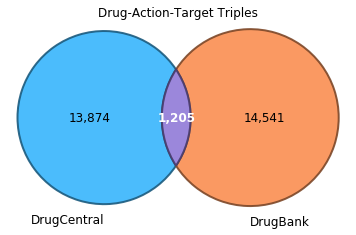

In [108]:
venn2([set(dc_trips), set(db_trips)], ['DrugCentral', 'DrugBank'], border=False)
plt.title('Drug-Action-Target Triples');

In [107]:
tgt_edges.head(2)

,start_id,end_id,type,source
0,IHUNBGSDBOWDMA-AQFIFDHZSA-N,5914,agonist,inxight_drugs
1,IHUNBGSDBOWDMA-UGOGCBOOSA-N,5914,agonist,inxight_drugs


In [109]:
ix_trips = []
for row in tgt_edges.itertuples():
    s = str(row.start_id).lower()
    p = str(row.type).lower()
    o = str(row.end_id).lower()    

    ix_trips.append((s, p, o))

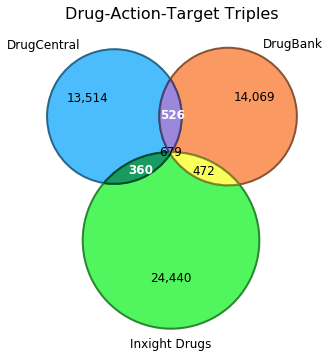

In [110]:
plt.figure(figsize=(10,6))
venn3([set(dc_trips), set(db_trips), set(ix_trips)], ['DrugCentral', 'DrugBank', 'Inxight Drugs'], border=False)
plt.title('Drug-Action-Target Triples', size=16);

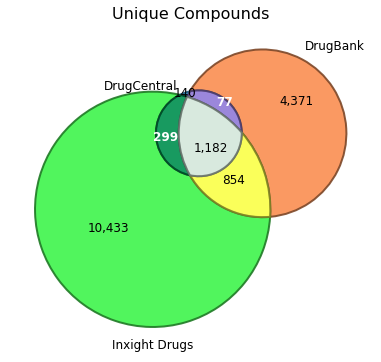

In [112]:
ix_comps = set(tgt_edges['start_id'])
db_comps = set(dbt_edges['start_id'])
dc_comps = set(dct_edges['start_id'])

plt.figure(figsize=(10, 6))
venn3([set(dc_comps), set(db_comps), set(ix_comps)], ['DrugCentral', 'DrugBank', 'Inxight Drugs'], border=False)
plt.title('Unique Compounds', size=16);

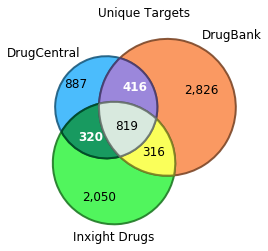

In [113]:
ix_tgts = set(tgt_edges['end_id'])
db_tgts = set(dbt_edges['end_id'])
dc_tgts = set(dct_edges['end_id'])

venn3([set(dc_tgts), set(db_tgts), set(ix_tgts)], ['DrugCentral', 'DrugBank', 'Inxight Drugs'], border=False)
plt.title('Unique Targets');

In [114]:
dbt_nodes['id_source'].value_counts()

entrez     3416
uniprot     839
other       122
Name: id_source, dtype: int64

In [115]:
dct_nodes['id_source'].value_counts()

entrez     2154
uniprot     259
other        29
Name: id_source, dtype: int64

In [116]:
targets['id_source'].value_counts()

entrez             2862
ChEMBL              647
GO Cell Process     530
UniProt             290
KEGG Pathway         56
Wiki Pathway         55
Name: id_source, dtype: int64

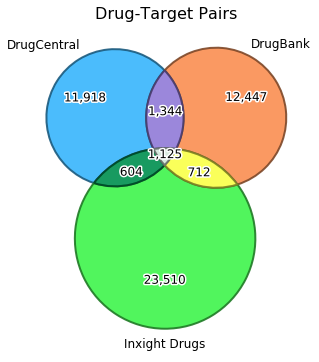

In [119]:
ix_so = []
for row in tgt_edges.itertuples():
    s = str(row.start_id).lower()
    o = str(row.end_id).lower()    

    ix_so.append((s, o))

dc_so = []
for row in dct_edges.itertuples():
    s = str(row.start_id).lower()
    o = str(row.end_id).lower()    

    dc_so.append((s, o))
    

db_so = []
for row in dbt_edges.itertuples():
    s = str(row.start_id).lower()
    o = str(row.end_id).lower()    

    db_so.append((s, o))

    
plt.figure(figsize=(10,6))
venn3([set(dc_so), set(db_so), set(ix_so)], ['DrugCentral', 'DrugBank', 'Inxight Drugs'])
plt.title('Drug-Target Pairs', size=16);

In [120]:
mc_targets = pd.merge(dct_nodes, dbt_nodes, how='outer', on='id')
dup_cols = [c for c in mc_targets.columns if c.endswith('_x')]

for col in dup_cols:
    other_col = col[:-1]+'y'
    mc_targets[col] = mc_targets[col].fillna(mc_targets[other_col])
    mc_targets = mc_targets.drop([other_col], axis=1)
    mc_targets = mc_targets.rename(columns={col: col[:-2]})
mc_targets = gt.order_cols(mc_targets)

In [121]:
final_targets = pd.merge(targets, mc_targets, how='outer', on='id')
dup_cols = [c for c in final_targets.columns if c.endswith('_x')]

for col in dup_cols:
    other_col = col[:-1]+'y'
    final_targets[col] = final_targets[col].fillna(final_targets[other_col])
    final_targets = final_targets.drop([other_col], axis=1)
    final_targets = final_targets.rename(columns={col: col[:-2]})
final_targets = gt.order_cols(final_targets)

In [122]:
all_nodes = pd.concat([chem_node_df, conditions, diseases, final_targets], sort=False)
all_edges = pd.concat([tgt_edges, ind_edges, dbt_edges, dct_edges], sort=False)

In [123]:
len(all_nodes), len(all_edges)

(118737, 86536)

In [124]:
combo = pd.merge(all_edges, all_nodes.rename(columns={c: 'start_'+c for c in all_nodes.columns}), how='left', on='start_id')
combo = pd.merge(combo, all_nodes.rename(columns={c: 'end_'+c for c in all_nodes.columns}), how='left', on='end_id')

In [125]:
comp_tar = combo.query('start_label == "Compound" and end_label == "Target"')

In [126]:
ix_entrz = comp_tar.query('source == "inxight_drugs" and end_id_source == "entrez"')
db_entrz = comp_tar.query('source == "drugbank" and end_id_source == "entrez"')
dc_entrz = comp_tar.query('source == "drugcentral" and end_id_source == "entrez"')

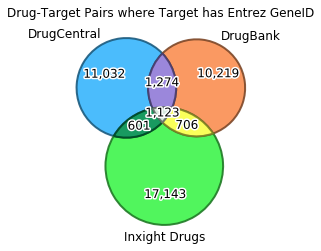

In [127]:
ix_so = []
for row in ix_entrz.itertuples():
    s = str(row.start_id).lower()
    o = str(row.end_id).lower()    

    ix_so.append((s, o))

dc_so = []
for row in dc_entrz.itertuples():
    s = str(row.start_id).lower()
    o = str(row.end_id).lower()    

    dc_so.append((s, o))
    

db_so = []
for row in db_entrz.itertuples():
    s = str(row.start_id).lower()
    o = str(row.end_id).lower()    

    db_so.append((s, o))

    
venn3([set(dc_so), set(db_so), set(ix_so)], ['DrugCentral', 'DrugBank', 'Inxight Drugs'])
plt.title('Drug-Target Pairs where Target has Entrez GeneID');

In [128]:
common_targets = set(dct_nodes['id']) & set(dbt_nodes['id']) & set(targets['id'])
len(common_targets)

973

In [129]:
common_drugs = set(dct_edges['start_id']) & set(dbt_edges['start_id']) & set(tgt_edges['start_id'])
len(common_drugs)

1182

In [130]:
ix_common = comp_tar.query('source == "inxight_drugs" and end_id in @common_targets and start_id in @common_drugs')
db_common = comp_tar.query('source == "drugbank" and end_id in @common_targets and start_id in @common_drugs')
dc_common = comp_tar.query('source == "drugcentral" and end_id in @common_targets and start_id in @common_drugs')

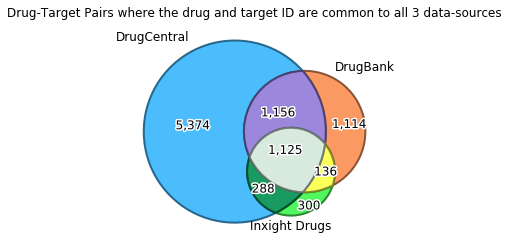

In [131]:
ix_so = []
for row in ix_common.itertuples():
    s = str(row.start_id).lower()
    o = str(row.end_id).lower()    

    ix_so.append((s, o))

dc_so = []
for row in dc_common.itertuples():
    s = str(row.start_id).lower()
    o = str(row.end_id).lower()    

    dc_so.append((s, o))
    

db_so = []
for row in db_common.itertuples():
    s = str(row.start_id).lower()
    o = str(row.end_id).lower()    

    db_so.append((s, o))

    
venn3([set(dc_so), set(db_so), set(ix_so)], ['DrugCentral', 'DrugBank', 'Inxight Drugs'])
plt.title('Drug-Target Pairs where the drug and target ID are common to all 3 data-sources');

In [150]:
all_nodes.to_csv(out_dir.joinpath('nodes_inxight.csv'), index=False)
all_edges.to_csv(out_dir.joinpath('edges_inxight.csv'), index=False)

# TODO: Gene symbol could be used to further map Uniprot to Entrez

In [139]:
all_nodes.query('label == "Target"').columns

Index(['id', 'name', 'label', 'chebi_id', 'chembl_id', 'drugbank_id', 'ikey',
       'mesh_id', 'unii_id', 'source', 'doid', 'target_chembl_id',
       'target_type', 'tax_id', 'id_source', 'xrefs', 'gene_symbol',
       'organism', 'swissprot_entry', 'target_class', 'uniprot_id'],
      dtype='object')

In [149]:
all_nodes.query('label == "Target" and id_source == "uniprot" and organism == "Homo sapiens"')

,id,name,label,chebi_id,chembl_id,drugbank_id,ikey,mesh_id,unii_id,source,...,target_chembl_id,target_type,tax_id,id_source,xrefs,gene_symbol,organism,swissprot_entry,target_class,uniprot_id
4449,P62158,Calmodulin,Target,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,uniprot,NaN,CALM1,Homo sapiens,CALM_HUMAN,Cytosolic other,P62158
4685,Q92753,Nuclear receptor ROR-beta,Target,NaN,NaN,NaN,NaN,NaN,NaN,Swiss-Prot,...,NaN,NaN,NaN,uniprot,NaN,RORB,Homo sapiens,RORB_HUMAN,Nuclear hormone receptor,Q92753
4803,O75343,Soluble guanylate cyclase,Target,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,uniprot,NaN,GUCY1A2|GUCY1B3|GUCY1B2|GUCY1A3,Homo sapiens,GCYB2_HUMAN|GCYA3_HUMAN|GCYB1_HUMAN|GCYA2_HUMAN,Enzyme,O75343
4953,P57078,Receptor-interacting serine/threonine-protein ...,Target,NaN,NaN,NaN,NaN,NaN,NaN,Swiss-Prot,...,NaN,NaN,NaN,uniprot,NaN,RIPK4,Homo sapiens,RIPK4_HUMAN,Kinase,P57078
5460,Q13748,Tubulin,Target,NaN,NaN,NaN,NaN,NaN,NaN,Swiss-Prot,...,NaN,NaN,NaN,uniprot,NaN,TUBB6|TUBB4B|TUBA3C|TUBB2A|TUBB|TUBA4A|TUBB8|T...,Homo sapiens,TBA1A_HUMAN|TBB4A_HUMAN|TBB6_HUMAN|TBB2B_HUMAN...,Structural,Q13748
5516,P06727,Apolipoprotein A-IV,Target,NaN,NaN,NaN,NaN,NaN,NaN,Swiss-Prot,...,NaN,NaN,NaN,uniprot,NaN,APOA4,Homo sapiens,NaN,NaN,P06727
5542,P01876,Ig alpha-1 chain C region,Target,NaN,NaN,NaN,NaN,NaN,NaN,Swiss-Prot,...,NaN,NaN,NaN,uniprot,NaN,IGHA1,Homo sapiens,NaN,NaN,P01876
5543,P01871,Ig mu chain C region,Target,NaN,NaN,NaN,NaN,NaN,NaN,Swiss-Prot,...,NaN,NaN,NaN,uniprot,NaN,IGHM,Homo sapiens,NaN,NaN,P01871
5544,P01599,Immunoglobulin kappa variable 1-17,Target,NaN,NaN,NaN,NaN,NaN,NaN,Swiss-Prot,...,NaN,NaN,NaN,uniprot,NaN,IGKV1-17,Homo sapiens,NaN,NaN,P01599
5545,P01619,Ig kappa chain V-III region GOL,Target,NaN,NaN,NaN,NaN,NaN,NaN,Swiss-Prot,...,NaN,NaN,NaN,uniprot,NaN,NaN,Homo sapiens,NaN,NaN,P01619


In [135]:
pd.DataFrame({'uniprot': list(uniprot_map.keys()), 'entrez': list(uniprot_map.values())})

,uniprot,entrez
0,Q14914,22949
1,Q9KKU4,2612546
2,P62491,8766
3,P9WPB7,887961
4,P9WNX3,887154
5,Q80UJ1,381203
6,P59796,257202
7,Q95214,NaN
8,Q6FHJ7,6424
9,O60779,10560
